#USE OF CYCLE GAN FOR GENERATING REALISTIC IMAGES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#IMPORTING ALL THE NECESSAERIES LIBRARY

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Set dataset path (Modify if needed)
dataset_path = "/content/drive/MyDrive/EDSR GAN IMAGES"

**Custom dataset class to load images from a folder**

**Define image transformations (resize, convert to tensor, and normalize)**

**Set dataset path, create dataset and DataLoader for batch processing**



In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Custom Dataset Class
class SmokeDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Open image in RGB mode

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image  # Return actual image tensor

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize image
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize between [-1, 1]
])

# Set Paths
dataset_path = "/content/drive/MyDrive/EDSR GAN IMAGES"
dataset = SmokeDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Creating Generator and Discriminator's Class**

In [11]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

**Create Generator and Discriminator instances**

**Define Loss Functions**

**Define Optimizers**

In [15]:
import torch.nn as nn
import torch.optim as optim


# Create Generator and Discriminator instances
G_A2B = Generator().to(device)  # Generator for A to B
G_B2A = Generator().to(device)  # Generator for B to A
D_A = Discriminator().to(device)  # Discriminator for A
D_B = Discriminator().to(device)  # Discriminator for B

# Define Loss Functions
criterion_GAN = nn.BCEWithLogitsLoss()  # or nn.MSELoss()  # Choose appropriate loss
criterion_cycle = nn.L1Loss()

# Define Optimizers
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


**TRAINED IT ON 100 EPOCHS**

In [16]:
epochs = 100

for epoch in range(epochs):
    for i, (real_A,) in enumerate(dataloader):  # Unpacking tuple
        real_A = real_A.to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        recovered_A = G_B2A(fake_B)

        fake_A = G_B2A(real_A)
        recovered_B = G_A2B(fake_A)

        # Train Discriminators
        optimizer_D_A.zero_grad()
        loss_D_A = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)).to(device)) + \
                   criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)).to(device))
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        loss_D_B = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)).to(device)) + \
                   criterion_GAN(D_B(real_A), torch.ones_like(D_B(real_A)).to(device))
        loss_D_B.backward()
        optimizer_D_B.step()

        # Train Generators
        optimizer_G.zero_grad()
        loss_G_A2B = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)).to(device))
        loss_G_B2A = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)).to(device))
        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_A)

        loss_G = loss_G_A2B + loss_G_B2A + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss G: {loss_G.item()}, Loss D_A: {loss_D_A.item()}, Loss D_B: {loss_D_B.item()}")

print("Training Complete!")


Epoch [1/100], Loss G: 3.859373092651367, Loss D_A: 1.389340877532959, Loss D_B: 1.384415626525879
Epoch [2/100], Loss G: 3.2354462146759033, Loss D_A: 1.386373519897461, Loss D_B: 1.3680305480957031
Epoch [3/100], Loss G: 3.569042205810547, Loss D_A: 1.3862998485565186, Loss D_B: 1.388521432876587
Epoch [4/100], Loss G: 4.196187496185303, Loss D_A: 1.3862946033477783, Loss D_B: 1.3863292932510376
Epoch [5/100], Loss G: 3.147515058517456, Loss D_A: 1.38631272315979, Loss D_B: 1.3779833316802979
Epoch [6/100], Loss G: 2.855008602142334, Loss D_A: 1.3862943649291992, Loss D_B: 1.3862941265106201
Epoch [7/100], Loss G: 3.0796587467193604, Loss D_A: 1.3863139152526855, Loss D_B: 1.3863173723220825
Epoch [8/100], Loss G: 2.474587917327881, Loss D_A: 1.386274814605713, Loss D_B: 1.3862215280532837
Epoch [9/100], Loss G: 2.727403163909912, Loss D_A: 1.3862988948822021, Loss D_B: 1.386389970779419
Epoch [10/100], Loss G: 3.4742989540100098, Loss D_A: 1.3863043785095215, Loss D_B: 1.38639533519

**FINAL OUTPUT OF GENRATED IMAGES**

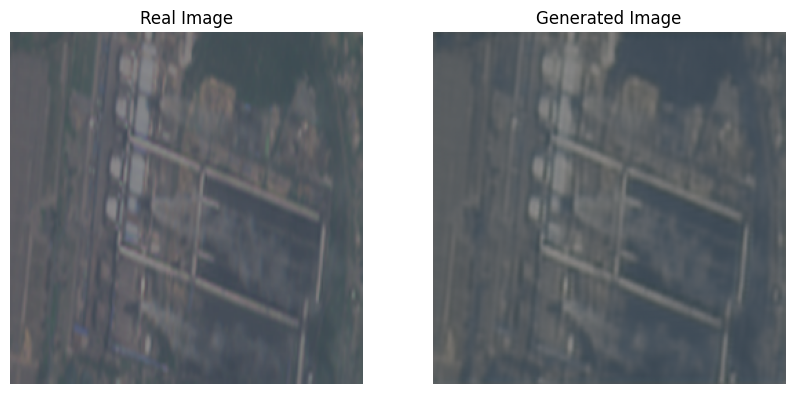

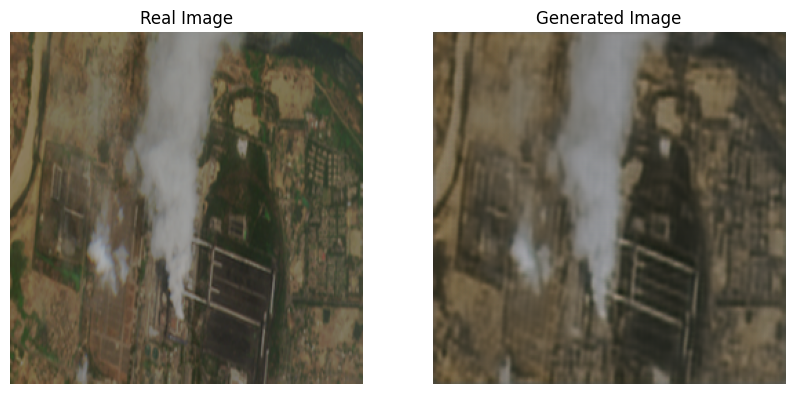

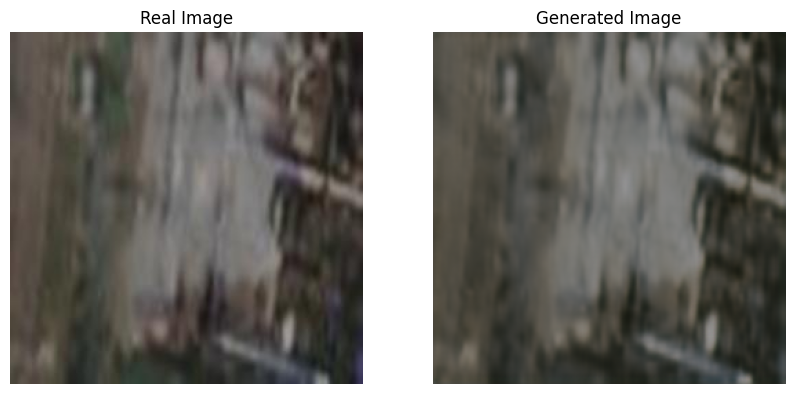

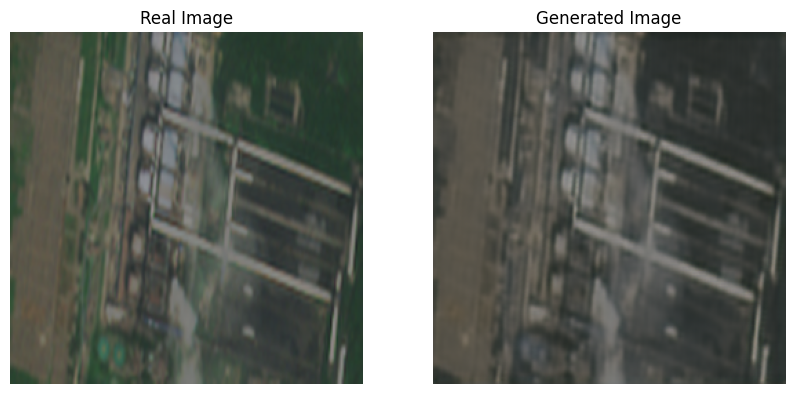

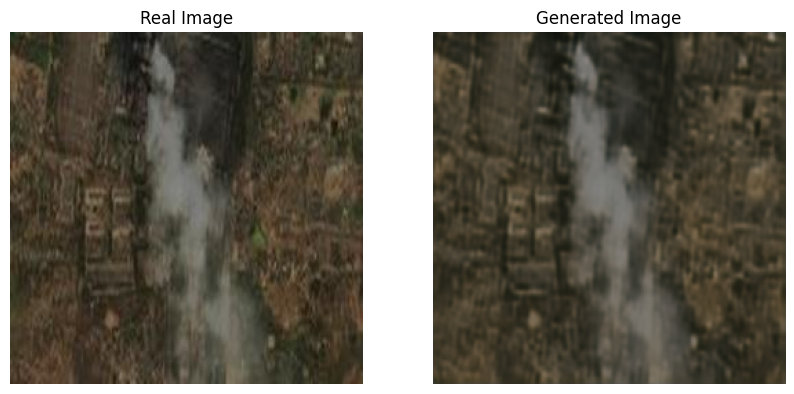

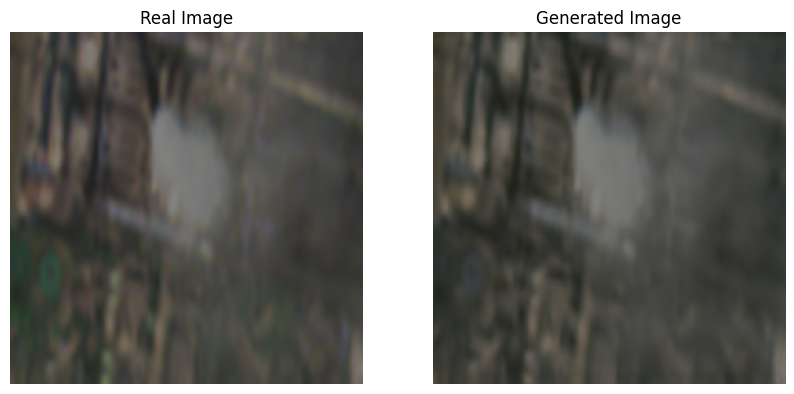

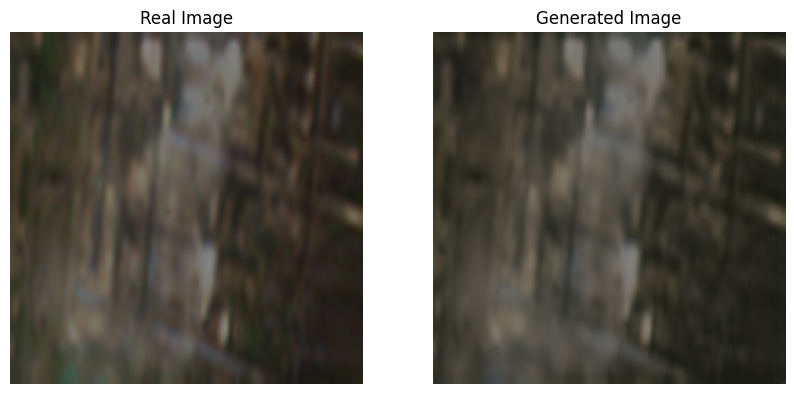

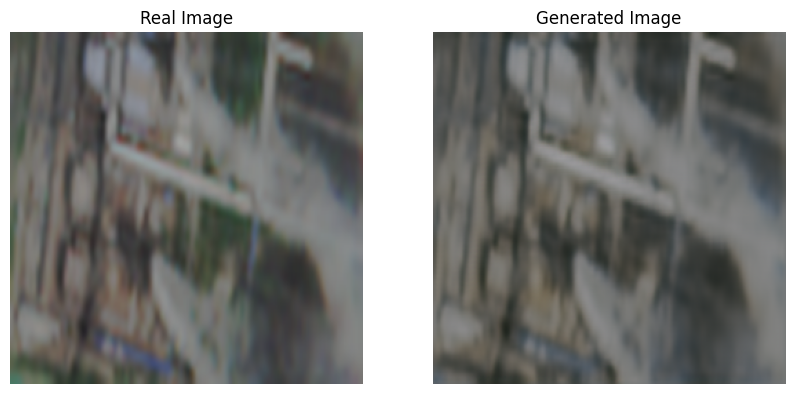

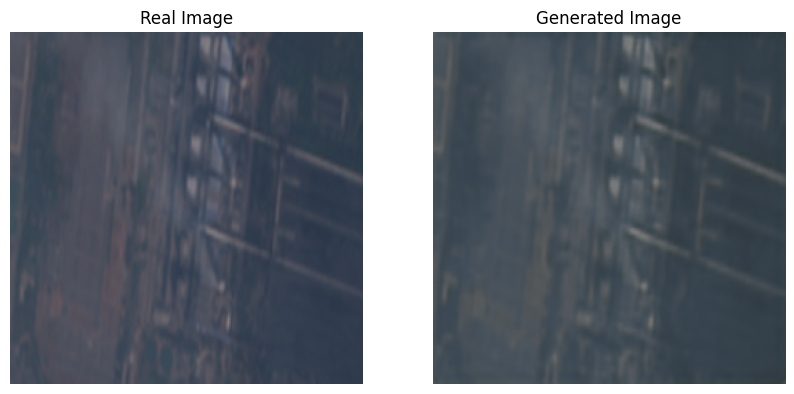

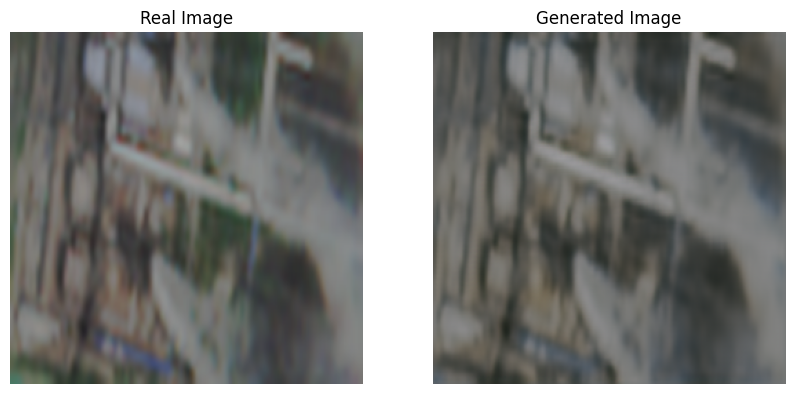

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# Folder to save generated images
output_folder = "generated_images"
os.makedirs(output_folder, exist_ok=True)

# Number of images to generate
num_images = 10

# Generate multiple images
for i in range(num_images):
    real_A = next(iter(dataloader))  # Get a real image
    real_A = real_A.to(device)

    with torch.no_grad():
        fake_B = G_A2B(real_A)  # Generate fake image

    # Convert tensors to images
    real_A_img = (real_A.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
    fake_B_img = (fake_B.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2

    # Plot and save images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(real_A_img)
    axs[0].set_title("Real Image")
    axs[0].axis("off")

    axs[1].imshow(fake_B_img)
    axs[1].set_title("Generated Image")
    axs[1].axis("off")

    plt.savefig(f"{output_folder}/generated_{i+1}.png")  # Save image
    plt.show()